In [21]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [2]:
# Changing Seaborn Theme To Dark
sns.set(style="darkgrid")

In [3]:
# Read CSV Files
train_data_raw = pd.read_csv("./data/train.csv")
test_data_raw = pd.read_csv("./data/test.csv")
train_data_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


# Exploratory Data Analysis (EDA)

## Missing Values

Com as função **.display_missing_values()**, podemos observar os valores ausentes em cada conjunto.

In [4]:
def display_missing_values(data):    
    for column in data.columns:          
        print(f"{column.capitalize()} - Missing values: {data[column].isnull().sum()}")

In [5]:
# Training Set
display_missing_values(train_data_raw)

Passengerid - Missing values: 0
Survived - Missing values: 0
Pclass - Missing values: 0
Name - Missing values: 0
Sex - Missing values: 0
Age - Missing values: 177
Sibsp - Missing values: 0
Parch - Missing values: 0
Ticket - Missing values: 0
Fare - Missing values: 0
Cabin - Missing values: 687
Embarked - Missing values: 2


* O conjunto de treinamento possui valores ausentes nas colunas: **Age**, **Cabin** e **Embarked** 

In [6]:
# Test Set
display_missing_values(test_data_raw)

Passengerid - Missing values: 0
Pclass - Missing values: 0
Name - Missing values: 0
Sex - Missing values: 0
Age - Missing values: 86
Sibsp - Missing values: 0
Parch - Missing values: 0
Ticket - Missing values: 0
Fare - Missing values: 1
Cabin - Missing values: 327
Embarked - Missing values: 0


* O conjunto de teste possui valores ausentes nas colunas:  **Age**, **Fare** e **Cabin**

Podemos lidar com os valores ausentes de diferentes formas. 
O método mais simples e radical consiste em remover todos os passageiros que possuam valores ausentes. No entanto essa abordagem reduziria o número de dados disponíveis. 
Outra alternativa seria preencher os valores ausentes com um valor qualquer, mas ao fazer isso podemos inserir ruídos e distorções ao nosso conjunto de dados. Portanto, devemos sempre pensar no contexto do problema antes de inserir valores nos conjuntos.

### Embarked

A Coluna Embarked armazena informações sobre o local de embarque dos passageiros.
Essa coluna possui apenas 2 valores ausentes, ambos no conjunto de treino. 
Portanto, a distorção causada pela inserção de um valor aleatório é baixa o suficiente para utilizarmos este método, sem comprometer o conjunto de dados.

In [7]:
train_data_raw[train_data_raw['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [8]:
# Filling The Missing Values In Embarked Column
embarked_values = train_data_raw["Embarked"].dropna().unique()
train_data_raw["Embarked"] = train_data_raw['Embarked'].fillna(embarked_values[random.randint(0, len(embarked_values))])

### Fare

A Coluna Fare armazena o valor da tarifa pago por cada passageiro.
Existe apenas um passageiro com o valor da tarifa ausente.
Como a tarifa é um valor tabelado, podemos usar um passageiro semelhante para aferir o valor da tarifa.

In [9]:
test_data_raw[test_data_raw["Fare"].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [10]:
# Filling The Missing Value In Fare With The Median Fare of passenger alone in 3rd Class  
fare = test_data_raw.groupby(["Pclass", "Parch", "SibSp"]).Fare.median()[3][0][0]
test_data_raw["Fare"] = test_data_raw["Fare"].fillna(fare)

### Age

A coluna Age armazena a idade de cada passageiro. 
Podemos usar a mediana ou a média de idade de todos os passageiros para preencher os valores ausentes.

In [11]:
median = train_data_raw["Age"].median()
print(f"Median Age: {median}")
mean = round(train_data_raw["Age"].sum()/train_data_raw["Age"].count(), 1)
print(f"Mean Age: {mean}")

Median Age: 28.0
Mean Age: 29.7


No entanto, se observarmos no histograma a seguir, é possível notar que a média e mediana varia conforme a idade e classe do passageiro. Portanto, a melhor opção seria inserir a mediana da idade para cada sexo por classe de passageiro.

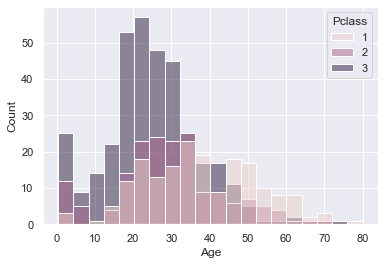

In [12]:
sns.histplot(data=train_data_raw, x="Age", hue="Pclass")
plt.show()

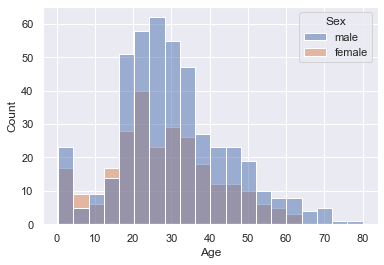

In [13]:
sns.histplot(data=train_data_raw, x="Age", hue="Sex")
plt.show()

In [14]:
age_by_pclass_and_sex = train_data_raw.groupby(["Sex", "Pclass"]).median()['Age']

for pclass in range(1, 4):
    for sex in ["female", "male"]:
        print(f"PClass: {pclass} \tSex: {sex.capitalize()} \tMedian Age: {age_by_pclass_and_sex[sex][pclass]}")

PClass: 1 	Sex: Female 	Median Age: 35.0
PClass: 1 	Sex: Male 	Median Age: 40.0
PClass: 2 	Sex: Female 	Median Age: 28.0
PClass: 2 	Sex: Male 	Median Age: 30.0
PClass: 3 	Sex: Female 	Median Age: 21.5
PClass: 3 	Sex: Male 	Median Age: 25.0


In [15]:
# Filling The Missing Values In Age Column
train_data_raw["Age"] = train_data_raw.groupby(["Sex", "Pclass"])["Age"].apply(lambda x: x.fillna(x.median()))
test_data_raw["Age"] = test_data_raw.groupby(["Sex", "Pclass"])["Age"].apply(lambda x: x.fillna(x.median()))

### Cabin

A coluna Cabine é um dado complexo, pois uma parte significativa da informação está faltando. 
Além disso, as cabines são os decks em que os quartos estão localizados, e esses quartos eram separados principalmente por classe. Portanto, podemos remover a coluna Cabin, já que ela está fortemente relacionada a classe dos passageiros.

In [16]:
train_data_raw = train_data_raw.drop("Cabin", axis=1)
test_data_raw = test_data_raw.drop("Cabin", axis=1)

Após a limpeza dos conjuntos, não encontramos mais valores ausentes. Agora podemos começar a explorar o nosso conjunto de dados.

In [17]:
train_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [18]:
test_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 32.8+ KB


## Passengers  Survival Distribution

In [25]:
survived_data = train_data_raw["Survived"].value_counts()

not_survived = round(survived_data[0] / train_data_raw.shape[0] * 100, 2)
survived = round(survived_data[1] / train_data_raw.shape[0] * 100, 2)

print(f"Survived: {survived} % of the training set...")
print(f"Not Survived: {not_survived} % of the training set...")

Survived: 38.38% of the training set...
Not Survived: 61.62% of the training set...


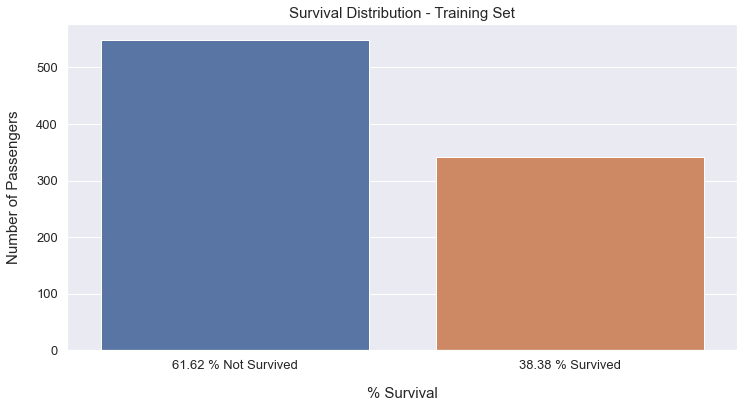

In [36]:
plt.figure(figsize=(12, 6))
sns.countplot(train_data_raw["Survived"])

plt.xlabel("% Survival", size=15, labelpad=15)
plt.ylabel("Number of Passengers", size=15, labelpad=15)
hues = [f"{not_survived} % Not Survived", f"{survived} % Survived"]
plt.xticks((0, 1), hues)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title("Survival Distribution - Training Set", size=15, y=1.0)

plt.show()

In [67]:
df = train_data_raw.groupby(["Survived","Sex"]).count()["PassengerId"].reset_index()
df.columns = ["Survived", "Sex", "Passengers"]
df

,Survived,Sex,Passengers
0,0,female,81
1,0,male,468
2,1,female,233
3,1,male,109


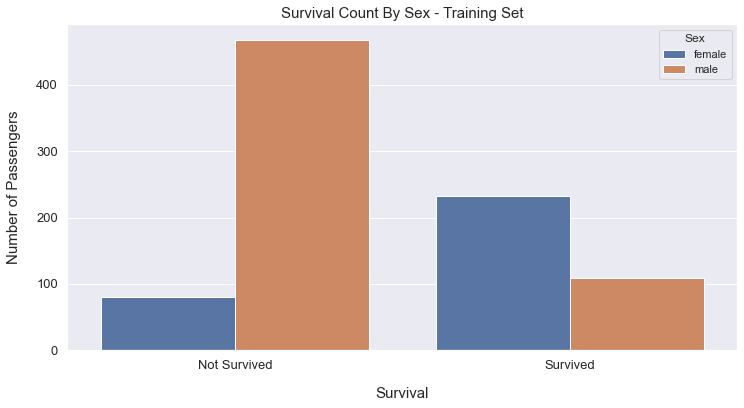

In [70]:
plt.figure(figsize=(12, 6))

sns.barplot(data=df, x="Survived", y="Passengers", hue="Sex")

plt.xlabel("Survival", size=15, labelpad=15)
plt.ylabel("Number of Passengers", size=15, labelpad=15)
hues = ["Not Survived", "Survived"]
plt.xticks((0, 1), hues)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title("Survival Count By Sex - Training Set", size=15, y=1.0)

plt.show()
